In [60]:
import numpy as np
import matplotlib.pyplot as plt

(512, 512)
<class 'numpy.ndarray'>
[[156 157 160 ... 152 152 152]
 [156 157 159 ... 152 152 152]
 [158 157 156 ... 152 152 152]
 ...
 [121 123 126 ... 121 113 111]
 [121 123 126 ... 121 113 111]
 [121 123 126 ... 121 113 111]]


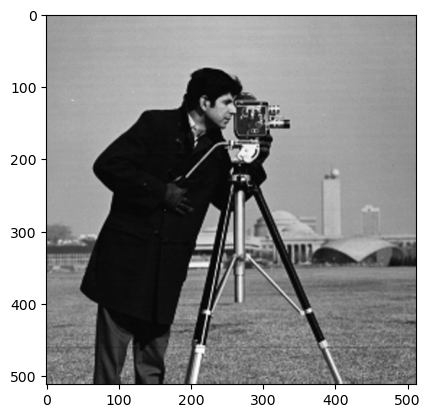

In [64]:
import cv2 as cv

pic_adress = 'test_pics\\standard cases\\cameraman.tif'

pic = cv.imread (pic_adress)
pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)
print (pic.shape)
print (type (pic))
print (pic [:,:])

plt.imshow (pic [:, :], cmap= 'gray')
plt.show ()


Phi:
[[111.00666809 129.12257966 129.71457132 130.45102662]
 [129.12257966 111.00666809 128.37016697 129.88946617]
 [129.71457132 128.37016697 111.00666809 128.37016697]
 [130.45102662 129.88946617 128.37016697 111.00666809]]

R:
[128.37016697 129.65775471 129.12257966 129.71457132]

aCoefs:
[0.32153522 0.22469757 0.24510487 0.24430938]

pic_recons size: (512, 512)


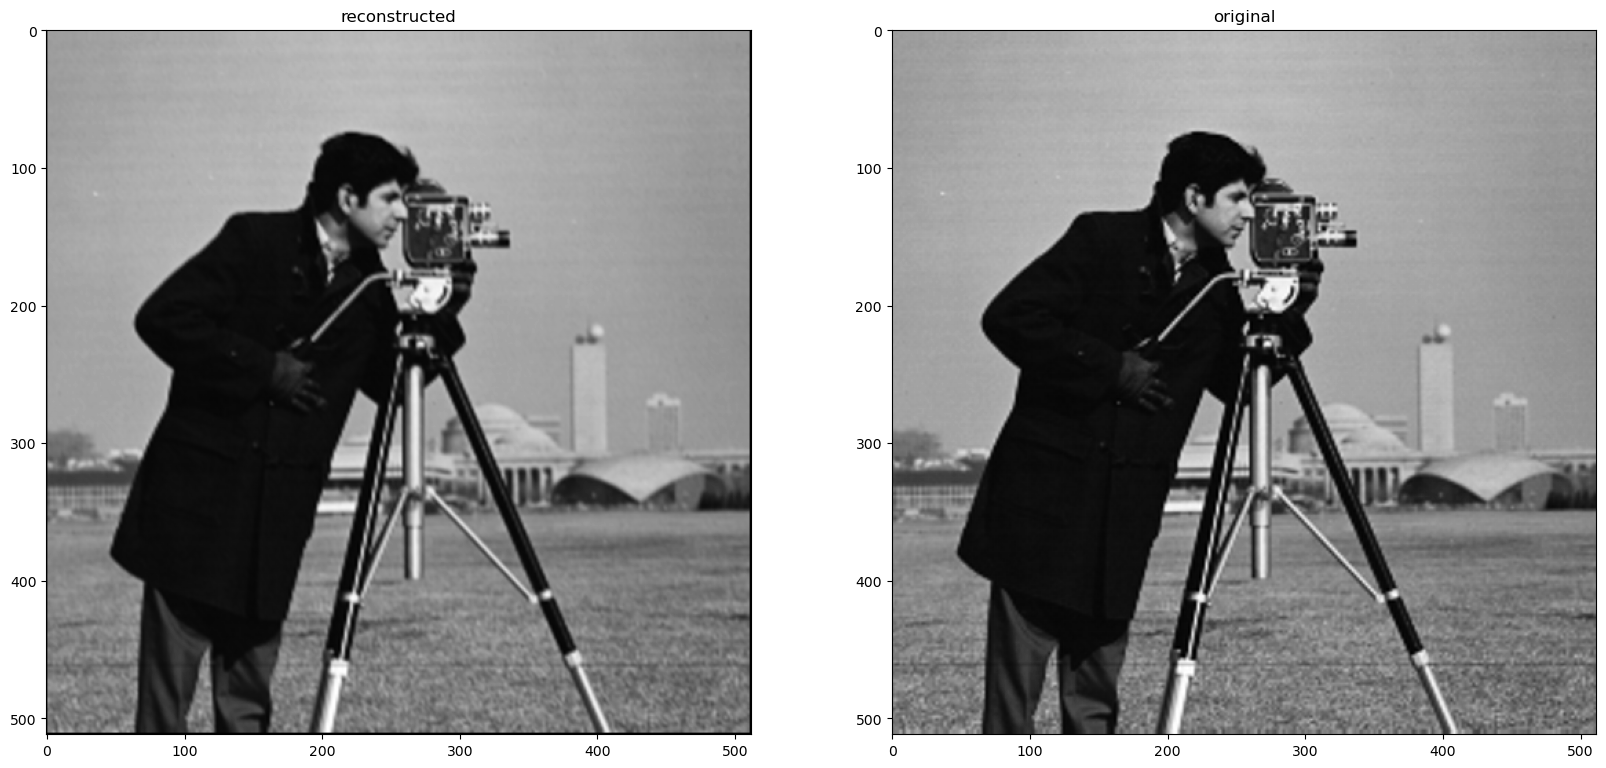

MSE Score:252.02684777741717


In [65]:
from numpy import mean

# Compression:

R22 = R33 = R44 = R55 = mean (mean (pic * pic))
R12 = R34 = R45 = mean ( mean (pic[: , 1:-1] * pic[: , 2:]))
R13 = mean (mean (pic[1:-1, 1:-1] * pic[2:, 2:]))
R14 = R23 = mean (mean (pic[1:-1 , :] * pic[2:, :]))
R15 = R24 = mean (mean (pic[2:, 1:-1] * pic[1:-1, 2:]))
R25 = mean (mean (pic[1:-1, 3:] * pic[2:, 1:-2]))
R35 = mean (mean (pic[:, 3:] * pic[:, 1:-2]))

Phi = np.array ([[R22, R23, R24, R25],
                 [R23, R22, R34, R35],
                 [R24, R34, R22, R45],
                 [R25, R35, R45, R22]])

R = np.array ([R12, R13, R14, R15])

aCoefs = np.matmul(np.linalg.inv(Phi) , R)

print ('\nPhi:\n{}\n'.format (Phi))
print ('R:\n{}\n'.format (R))
print ('aCoefs:\n{}\n'.format (aCoefs))

# Reconstruction:

pic_recons_fromzero = np.zeros (pic.shape, dtype='double')
pic_recons_fromzero[:,0] = pic[:,0]
pic_recons_fromzero[0,:] = pic[0,:]

print ('pic_recons size: {}'.format (pic_recons_fromzero.shape))


for i in range (1 , pic.shape[0]-1):
    for j in range (1, pic.shape[1]-1):
        pic_recons_fromzero [i, j] = aCoefs[0]*pic_recons_fromzero[i-1,j] + aCoefs[1]*pic_recons_fromzero[i-1,j+1] + aCoefs[2]*pic_recons_fromzero[i,j+1] + aCoefs[3]*pic_recons_fromzero[i+1,j+1]

# plt.imshow (pic_recons_fromzero)

pic_recons_frompic = np.zeros (pic.shape, dtype='double')

for i in range (1 , pic.shape[0]-1):
    for j in range (1, pic.shape[1]-1):
        pic_recons_frompic [i, j] = aCoefs[0]*pic[i-1,j] + aCoefs[1]*pic[i-1,j+1] + aCoefs[2]*pic[i,j+1] + aCoefs[3]*pic[i+1,j+1]

plt.figure (figsize=(20,10))
plt.subplot (1,2,1)
plt.imshow (pic_recons_frompic, cmap='gray')
plt.title (label='reconstructed')
plt.subplot (1,2,2)
plt.imshow (pic, cmap='gray')
plt.title (label='original')
plt.show()

def mse(img1, img2): # MSE Score
   h, w = img1.shape
   diff = abs (img1 - img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse

mse_score = mse(pic, pic_recons_frompic)
print ('MSE Score:{}'.format (mse_score))



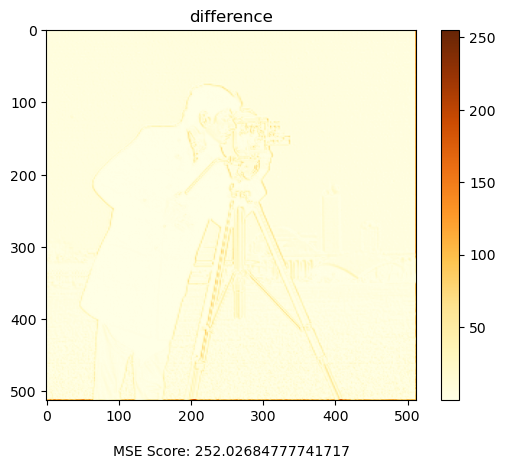

[[156.         157.         160.         ... 152.         152.
  152.        ]
 [156.           6.51657966   5.01138287 ...   5.41835134   5.41835134
  152.        ]
 [158.           5.0679487    6.48632157 ...   5.41835134   5.41835134
  152.        ]
 ...
 [121.           7.42571271   6.22706411 ...   0.98122892   1.82896244
  111.        ]
 [121.           6.52692242   4.49152808 ...   1.39960178   2.5998928
  111.        ]
 [121.         123.         126.         ... 121.         113.
  111.        ]]


In [66]:
# plt.imshow (cv.absdiff (pic, pic_recons_frompic), cmap= 'YlOrBr')
plt.imshow (abs (pic - pic_recons_frompic), cmap= 'YlOrBr')
plt.title (label='difference')
plt.xlabel ('\nMSE Score: {}'.format (mse_score))
plt.colorbar ()
plt.show()
print (abs (pic - pic_recons_frompic))